# Project 4: Movie Recommendation

In this notebook, we will be recommending movies based on 1 million anonymous ratings of approximately 3,900 movies reviewed by 6,040 MovieLens users who joined MovieLens in 2000.  


## Table of Contents

I.  [Load Data](#Load-Data)<br>
II. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
III.[Genre Based Recommendations](#Genre)<br>
IV. [User Based Collaborative Filtering](#User)<br>
V.  [Item Based Collaborative Filtering](#Item)<br>
VI. [Matrix Factorization using SVD](#Matrix-Fact)<br>
VII.[Collaborative Filtering Based Recommendations](#Collaborative)<br>

### <a class="anchor" id="Load-Data">Part I : Load Data</a>

`1.` Import libraries

In [696]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import KNNWithMeans
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

%matplotlib inline

`2.` Load ratings data

In [641]:
myurl = "https://liangfgithub.github.io/MovieData/ratings.dat"
ratings = pd.read_csv(myurl,encoding='latin1',sep='::',header=None,engine='python')
ratings.columns=['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings.drop(columns='Timestamp',inplace=True)
ratings.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


`3.` Load movies data, extract year from movie title and one hot-encode genre

In [642]:
myurl = "https://liangfgithub.github.io/MovieData/movies.dat"
movies = pd.read_csv(myurl,encoding='latin1',sep='::',header=None,engine='python')
movies.columns=['MovieID', 'Title', 'Genres']
movies['Year'] = movies['Title'].apply(lambda x:x[-5:-1])

genre_list = ["Action", "Adventure", "Animation", 
               "Children's", "Comedy", "Crime",
               "Documentary", "Drama", "Fantasy",
               "Film-Noir", "Horror", "Musical", 
               "Mystery", "Romance", "Sci-Fi", 
               "Thriller", "War", "Western"]
for genre in genre_list:
    movies[genre] = movies['Genres'].apply(lambda x:1 if genre in x else 0)
movies.head()

,MovieID,Title,Genres,Year,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


`4.` Load users data

In [643]:
myurl = "https://liangfgithub.github.io/MovieData/users.dat"
users = pd.read_csv(myurl,encoding='latin1',sep='::',header=None,engine='python')
users.columns=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


### <a class="anchor" id="Exploratory-Data-Analysis">Part II : Exploratory Data Analysis</a>

`1.` Check for duplicate values

In [644]:
movies['MovieID'].duplicated().any() # True

False

There are no duplicate movie ids in movies dataframe

In [645]:
users['UserID'].duplicated().any() # True

False

There are no duplicate user ids in users dataframe

In [646]:
ratings[['UserID','MovieID']].duplicated().any() # True

False

There are no duplicate reviews by user for any movie

`2.` Check for missing values

In [647]:
len(set(movies['MovieID']) - set(ratings['MovieID']))

177

There are 177 movies that have no reviews

In [648]:
len(set(ratings['MovieID']) - set(movies['MovieID']))

0

All rated movies are listed in movies dataframe

In [649]:
unique_movies = ratings['MovieID'].nunique()
total_movies = movies['MovieID'].nunique()
unique_users = users['UserID'].nunique()
user_movie_reviews = ratings.shape[0]
print('Unique movies with reviews: {}\nTotal movies: {}\nUnique users: {}\nUser-movie \
reviews: {}\n'.format(unique_movies, total_movies, unique_users, user_movie_reviews))

Unique movies with reviews: 3706
Total movies: 3883
Unique users: 6040
User-movie reviews: 1000209



`3.` Calculate overall movie rating and popularity<br><br>
Let's calculate the average rating and number of ratings per movie and merge this back with movies dataframe  using an inner join which, in turn, will remove movies that have received no ratings

In [650]:
averatings = ratings.groupby('MovieID')['Rating'].mean()
averatings.name = 'AveRating'
movies = movies.merge(averatings,on='MovieID')

numratings = ratings.groupby('MovieID')['Rating'].count()
numratings.name = 'NumRatings'
movies = movies.merge(numratings,on='MovieID')

movies.head()

,MovieID,Title,Genres,Year,Action,Adventure,Animation,Children's,Comedy,Crime,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,AveRating,NumRatings
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,4.146846,2077
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,3.201141,701
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,3.016736,478
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2.729412,170
4,5,Father of the Bride Part II (1995),Comedy,1995,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3.006757,296


In [651]:
unique_movies = ratings['MovieID'].nunique() # The number of unique articles that have at least one interaction
total_movies = movies['MovieID'].nunique() # The number of unique articles on the IBM platform
unique_users = users['UserID'].nunique() # The number of unique users
user_movie_reviews = ratings.shape[0] # The number of user-article interactions
print('Unique movies with reviews: {}\nTotal movies: {}\nUnique users: {}\nUser-movie \
reviews: {}\n'.format(unique_movies, total_movies, unique_users, user_movie_reviews))

Unique movies with reviews: 3706
Total movies: 3706
Unique users: 6040
User-movie reviews: 1000209



After the merge, we only have the 3706 movies that have ratings

`3.` Additional Exploration of movies, ratings and users

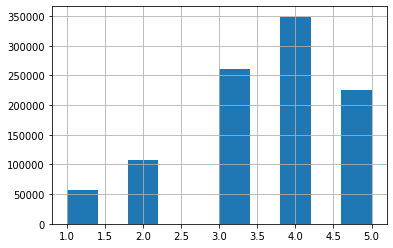

In [478]:
ratings['Rating'].hist()

Most movies are rated a 4, there are fewer movies with rating of 1 than a 5, the distribution is left-skewed

In [652]:
ratings['UserID'].value_counts().describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: UserID, dtype: float64

Minimum number of movies reviewed by a user is 20 and maximum number of movies reviewed by a user is 2314

In [653]:
movies[['Title','NumRatings']].sort_values('NumRatings',ascending=False).head()

,Title,NumRatings
2651,American Beauty (1999),3428
253,Star Wars: Episode IV - A New Hope (1977),2991
1106,Star Wars: Episode V - The Empire Strikes Back...,2990
1120,Star Wars: Episode VI - Return of the Jedi (1983),2883
466,Jurassic Park (1993),2672


The most reviewed movie in the dataset is American Beauty and was reviewed 3428 times

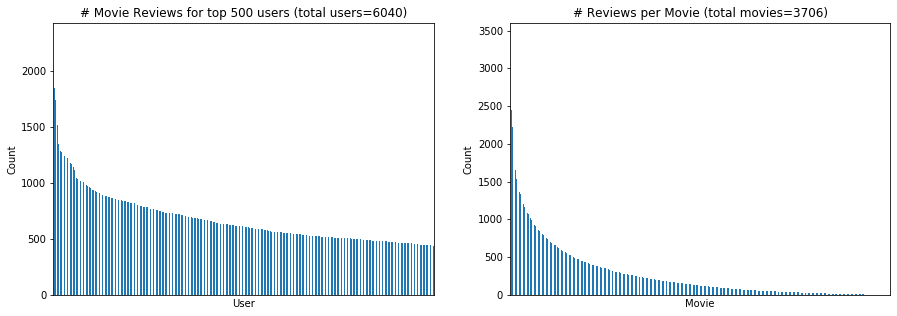

In [654]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
ratings['UserID'].value_counts()[:500].plot(kind='bar',ax=axes[0])
axes[0].set(xlabel='User',ylabel='Count',title='# Movie Reviews for top 500 users (total users=6040)',xticks=[])
ratings['MovieID'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set(xlabel='Movie',ylabel='Count',title='# Reviews per Movie (total movies=3706)',xticks=[])
plt.show()

### <a class="anchor" id="Genre">Part III: Genre-Based Recommendations</a>

We'll use the average rating and number of ratings aggregated in Part II to recommend movies for each genre.<br>
**For movies recommended by rating, we'll require that there are at least 100 reviews.**<br>
**For movies recommended by popularity, we'll require that the average rating is at least 2.**

In [658]:
def get_top_movies_by_rating(genre, n):
    return movies[(movies['NumRatings']>100) & (movies[genre]==1)].sort_values('AveRating', \
    ascending=False)[['MovieID','Title','AveRating','NumRatings']][:n]
 
def get_top_movies_by_popularity(genre, n):
    return movies[(movies['AveRating']>2) & (movies[genre]==1)].sort_values('NumRatings', \
    ascending=False)[['MovieID','Title','AveRating','NumRatings']][:n]

In [659]:
n=5
for genre in genre_list:
    print(genre)
    print('-'*75)
    print('By Rating')
    print(get_top_movies_by_rating(genre,n)[['Title','AveRating','NumRatings']].to_string(index=False))
    print('By Poplularity')
    print(get_top_movies_by_popularity(genre,n)[['Title','AveRating','NumRatings']].to_string(index=False))
    print('-'*75)

Action
---------------------------------------------------------------------------
By Rating
                                             Title  AveRating  NumRatings
 Seven Samurai (The Magnificent Seven) (Shichin...   4.560510         628
                             Godfather, The (1972)   4.524966        2223
                    Raiders of the Lost Ark (1981)   4.477725        2514
         Star Wars: Episode IV - A New Hope (1977)   4.453694        2991
                    Godfather: Part II, The (1974)   4.357565        1692
By Poplularity
                                             Title  AveRating  NumRatings
         Star Wars: Episode IV - A New Hope (1977)   4.453694        2991
 Star Wars: Episode V - The Empire Strikes Back...   4.292977        2990
 Star Wars: Episode VI - Return of the Jedi (1983)   4.022893        2883
                              Jurassic Park (1993)   3.763847        2672
                        Saving Private Ryan (1998)   4.337354        2653
----

                      Title  AveRating  NumRatings
      Close Shave, A (1995)   4.520548         657
 Usual Suspects, The (1995)   4.517106        1783
         Rear Window (1954)   4.476190        1050
      Third Man, The (1949)   4.452083         480
    Sixth Sense, The (1999)   4.406263        2459
By Poplularity
                             Title  AveRating  NumRatings
 Terminator 2: Judgment Day (1991)   4.058513        2649
                Matrix, The (1999)   4.315830        2590
  Silence of the Lambs, The (1991)   4.351823        2578
                      Fargo (1996)   4.254676        2513
           Sixth Sense, The (1999)   4.406263        2459
---------------------------------------------------------------------------
War
---------------------------------------------------------------------------
By Rating
                                             Title  AveRating  NumRatings
                           Schindler's List (1993)   4.510417        2304
                 

### <a class="anchor" id="User">Part IV: User Based Collaborative Filtering</a>

We'll use the surprise library to predict the ratings. Let's load the data

In [660]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['UserID', 'MovieID', 'Rating']], reader)

We'll use `KNNWithMeans` algorithm from surprise library. This is a basic collaborative filtering algorithm that takes into account mean ratings of each user. The prediction is set as:

$$\hat{r}_{ui} = \mu_u + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - \mu_v)} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)}$$

We'll leave min number of neighbors,`min_k`, and maximum number of neighbors, `k` to default, 1 and 40 respectively. For `sim_options`, which is a dicitonary of options for the similarity measure, we'll use `cosine` (cosine similarity) and `user_based` set to `True` to compute similarities between users.<br><br>

We'll use the built-in `cross_validate` function to evaluate the model. The data will be split into 10 folds, where 90% of the data will be used for training and remaining 10% will be used for testing for each fold. We'll evaluate the `RMSE` (Root Mean Squared Error) for each fold.

In [667]:
# To use user-based cosine similarity
sim_options = {"name": "cosine", "user_based": True}

algo = KNNWithMeans(sim_options=sim_options)

# Run 10-fold cross-validation and print results.
cv_dict_user = cross_validate(algo, data, measures=['RMSE'], cv=10)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [671]:
run_time = (sum(cv_dict_user['fit_time']) + sum(cv_dict_user['test_time']))/60
print('The algorithm took {:.1f} minutes to run across all splits'.format(run_time))

The algorithm took 28.5 minutes to run across all splits


### <a class="anchor" id="Item">Part V: Item Based Collaborative Filtering</a>

We'll again use KNNWithMeans algorithm from surprise library. This is a basic collaborative filtering algorithm that takes into account mean ratings of each user. The prediction is set as:

$$\hat{r}_{ui} = \mu_i + \frac{ \sum\limits_{j \in N^k_u(i)}
\text{sim}(i, j) \cdot (r_{uj} - \mu_j)} {\sum\limits_{j \in
N^k_u(i)} \text{sim}(i, j)}$$

We'll leave min number of neighbors and maximum number of neighbors to default, 1 and 40 respectively. For sim_options, we'll use cosine similarity and user_based set to False to compute similarities between items.

In [673]:
# To use item-based cosine similarity
sim_options = {"name": "cosine", "user_based": False}

algo = KNNWithMeans(sim_options=sim_options)

# Run 5-fold cross-validation and print results.
cv_dict_item = cross_validate(algo, data, measures=['RMSE'], cv=10)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [674]:
run_time = (sum(cv_dict_item['fit_time']) + sum(cv_dict_item['test_time']))/60
print('The algorithm took {:.1f} minutes to run across all splits'.format(run_time))

The algorithm took 11.5 minutes to run across all splits


### <a class="anchor" id="Matrix-Fact">Part VI: Matrix Factorization using SVD</a>

Now we'll use SVD to predict ratings. We'll leave the number of latent factors, `n_factors` to 100<br>

The prediction is set to 
$$\hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$$

where $q_i$ are item factors and $p_u$ are user factors. $b_u$ and $b_i$ are the user and item bias terms respectively.<br>

We minimize the following regularized squared error

$$\sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right)$$

We'll use default paramters for the algorithm

`n_factors=100` - The number of factors<br>
`n_epochs=20` – The number of iterations<br>
`init_mean=0` – The mean of the normal distribution for factor vectors initialization<br>
`init_std_dev=0.1` – The standard deviation of the normal distribution for factor vectors initialization<br>
`lr_all=0.005` – The learning rate for all parameters<br>
`reg_all=0.02` – The regularization term for all parameters<br>

In [675]:
algo = SVD()

# Run 10-fold cross-validation and print results.
cv_dict_svd = cross_validate(algo, data, measures=['RMSE'], cv=10)

In [676]:
run_time = (sum(cv_dict_svd['fit_time']) + sum(cv_dict_svd['test_time']))/60
print('The algorithm took {:.1f} minutes to run across all splits'.format(run_time))

The algorithm took 9.6 minutes to run across all splits


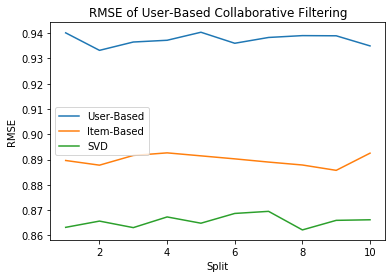

In [701]:
plt.xlabel("Split")
plt.ylabel("RMSE")
plt.plot(range(1,11), cv_dict_user['test_rmse'],label='User-Based')
plt.plot(range(1,11), cv_dict_item['test_rmse'],label='Item-Based')
plt.plot(range(1,11), cv_dict_svd['test_rmse'],label='SVD')
plt.title("RMSE of User-Based Collaborative Filtering")
plt.legend()
plt.show()

### <a class="anchor" id="Collaborative">Part VII : Collaborative Filtering based Recommendations</a>

`1.` Get movies for the user to rate, we can either have the user rate popular movies or pick movies at random, we'll use popular movies

In [694]:
def get_popular_movies(n):
    return movies.sort_values('NumRatings', ascending=False)[['MovieID','Title','AveRating']][:n]

def get_random_movies(n):
    return movies.sample(n)[['MovieID','Title','AveRating','NumRatings']]

In [678]:
movies_to_rate = get_popular_movies(50)
movies_gt_200_ratings = movies[movies['NumRatings']>200]

`2.` The rating mechanism is implemented in the app. For testing purposes, we'll generate a random rating for each movie from 0-5, 0 will mean that the user did not rate the movie. For each rating that is not a 0, we'll append this to the ratings dataframe. We'll use `UserID` 9999 to denote this new user to avoid conflict with the existing users.<br><br>
We'll only predict on movies that have at least 200 reviews, this is to avoid recommending movies that may have been reviewed too few times and aren't popular. Additionally, we'll leave out the prediciton for the movies that the user just rated.

In [679]:
uid = 9999
random_ratings = np.random.randint(0,6,50)
for i, rating in enumerate(random_ratings):
    if rating!=0:
        ratings = ratings.append({'UserID':9999,'MovieID':movies_to_rate.iloc[i,0],'Rating':rating},ignore_index=True)

`2.` We'll read the new data into the `surprise` data object and train the whole dataset.

In [680]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['UserID', 'MovieID', 'Rating']], reader)
trainset = data.build_full_trainset()

We'll write a function to take in the trained algorithm and return predictions.

In [681]:
def get_recommendations(algo, n):
    all_recs = {}

    for iid in ratings['MovieID'].unique():
        if (iid not in movies_to_rate['MovieID'].values) and (iid in movies_gt_200_ratings['MovieID'].values):
            est = algo.predict(uid,iid).est
            all_recs[iid]=est
    top_n = sorted(all_recs.items(), key=lambda x: x[1], reverse=True)[:n]
    top_n_ids = [x[0] for x in top_n]
    
    top_movies = movies[movies['MovieID'].isin(top_n_ids)]
    
    return top_movies[['MovieID','Title','AveRating','NumRatings']]

`3.` Let's make recommendations using all three methods - User-based, Item-based and SVD

In [685]:
sim_options = {"name": "cosine", "user_based": True}
algo = KNNWithMeans(sim_options=sim_options)
algo.fit(trainset)
print('User-Based Collaborative Filtering Recommendations')
top_movies = get_recommendations(algo,10)
top_movies

Computing the cosine similarity matrix...
Done computing similarity matrix.
User-Based Collaborative Filtering Recommendations


,MovieID,Title,AveRating,NumRatings
713,750,Dr. Strangelove or: How I Learned to Stop Worr...,4.449890,1367
847,908,North by Northwest (1959),4.384030,1315
852,913,"Maltese Falcon, The (1941)",4.395973,1043
855,916,Roman Holiday (1953),4.216471,425
861,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.491489,470
892,953,It's a Wonderful Life (1946),4.299040,729
1066,1148,"Wrong Trousers, The (1993)",4.507937,882
1117,1207,To Kill a Mockingbird (1962),4.425647,928
2809,3022,"General, The (1927)",4.368932,206
3664,3911,Best in Show (2000),4.073059,657


In [688]:
sim_options = {"name": "cosine", "user_based": False}
algo = KNNWithMeans(sim_options=sim_options)
algo.fit(trainset)
print('Item-Based Collaborative Filtering Recommendations')
top_movies = get_recommendations(algo,10)
top_movies

Computing the cosine similarity matrix...
Done computing similarity matrix.
Item-Based Collaborative Filtering Recommendations


,MovieID,Title,AveRating,NumRatings
689,720,Wallace & Gromit: The Best of Aardman Animatio...,4.426941,438
708,745,"Close Shave, A (1995)",4.520548,657
713,750,Dr. Strangelove or: How I Learned to Stop Worr...,4.449890,1367
843,904,Rear Window (1954),4.476190,1050
861,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.491489,470
1066,1148,"Wrong Trousers, The (1993)",4.507937,882
1090,1178,Paths of Glory (1957),4.473913,230
1117,1207,To Kill a Mockingbird (1962),4.425647,928
1122,1212,"Third Man, The (1949)",4.452083,480
1839,2019,Seven Samurai (The Magnificent Seven) (Shichin...,4.560510,628


In [689]:
algo = SVD()
algo.fit(trainset)
print('SVD-Based Collaborative Filtering Recommendations')
top_movies = get_recommendations(algo,10)
top_movies

Item-Based Collaborative Filtering Recommendations


,MovieID,Title,AveRating,NumRatings
837,898,"Philadelphia Story, The (1940)",4.300687,582
838,899,Singin' in the Rain (1952),4.283622,751
851,912,Casablanca (1942),4.412822,1669
894,955,Bringing Up Baby (1938),4.169492,413
908,969,"African Queen, The (1951)",4.251656,1057
970,1035,"Sound of Music, The (1965)",3.931973,882
1281,1380,Grease (1978),3.577723,817
1767,1947,West Side Story (1961),4.057819,761
2131,2324,Life Is Beautiful (La Vita è bella) (1997),4.329861,1152
2809,3022,"General, The (1927)",4.368932,206
